This code collects 1 year historical data from 2024-02-12 to 2025-01-10. The columns that will be collected are:
1. Futures price
2. Spot price
3. Funding rate

This is a list of popular coins. This code will be used to collect data on bitcoin, ethereum and solana.
1. BTCUSDT (Bitcoin) is the first and largest cryptocurrency by market capitalization.
2. ETHUSDT (ETH) is the second-largest cryptocurrency, known for its smart contract capabilities and decentralized applications (DApps). Unlike Bitcoin, which primarily serves as digital money, Ethereum powers a wide range of use cases, including DeFi (Decentralized Finance), NFTs, and enterprise blockchain solutions.
3. SOLUSDT (Solana) – Fast and scalable, growing ecosystem
4. BNBUSDT (Binance Coin) – Strong use case, widely adopted
5. XRPUSDT (Ripple) – Used for cross-border payments
6. ADAUSDT (Cardano) – Research-driven blockchain
7. DOGEUSDT (Dogecoin) – High community support, sometimes volatile

### Part 0. Inputs

In [ ]:
symbol_input = 'SOLUSDT'
end_time = datetime.strptime("2025-01-10 16:00:00", "%Y-%m-%d %H:%M:%S")
start_time = datetime.strptime("2024-02-12 16:00:00", "%Y-%m-%d %H:%M:%S")

### Part 1. Import libraires and Define the functions 

In [ ]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta

# Binance API URLs
spot_url = "https://api.binance.com/api/v1/klines"
futures_url = "https://fapi.binance.com/fapi/v1/klines"
funding_rate_url = "https://fapi.binance.com/fapi/v1/fundingRate"

# Convert time to milliseconds
start_time_ms = int(time.mktime(start_time.timetuple()) * 1000)
end_time_ms = int(time.mktime(end_time.timetuple()) * 1000)

# Function to fetch historical data - for spot price and futures price
def fetch_data(url, symbol, interval, start_time, end_time, limit):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data

# Function to fetch funding rate data
def fetch_funding_rate(symbol, start_time, end_time):
    funding_rate_data = []
    # Funding rate is updated every 8 hours, fetch in chunks
    while start_time < end_time:
        params = {
            'symbol': symbol,
            'startTime': start_time,
            'endTime': min(start_time + 8 * 60 * 60 * 1000, end_time),  # 8 hours in ms
        }
        response = requests.get(funding_rate_url, params=params)
        data = response.json()
        funding_rate_data.extend(data)
        start_time += 8 * 60 * 60 * 1000  # Move 8 hours forward
    return funding_rate_data

### Part 2. Get Funding Rate, Futures Price and Spot Price Data

##### 1. Funding Rate Data

In [3]:
# Fetch funding rate data - takes around 2+ minutes
funding_data = fetch_funding_rate(symbol_input, start_time_ms, end_time_ms)
funding_rate_df =pd.DataFrame(funding_data, columns=['symbol', 'fundingTime', 'fundingRate', 'markPrice'])

In [4]:
filtered_funding_rate_df = funding_rate_df[['fundingTime','fundingRate']]
filtered_funding_rate_df = filtered_funding_rate_df.rename(columns={'fundingTime': 'timestamp', 'fundingRate': 'funding_rate'}) # Rename the columns
filtered_funding_rate_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_funding_rate_df['timestamp'], unit='ms')

C:\Users\julia\AppData\Local\Temp\ipykernel_18352\892491588.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-02-12 08:00:00', '2024-02-12 16:00:00', '2024-02-12 16:00:00',
 '2024-02-13 00:00:00', '2024-02-13 00:00:00', '2024-02-13 08:00:00',
 '2024-02-13 08:00:00', '2024-02-13 16:00:00', '2024-02-13 16:00:00',
 '2024-02-14 00:00:00',
 ...
 '2025-01-08 16:00:00', '2025-01-09 00:00:00', '2025-01-09 00:00:00',
 '2025-01-09 08:00:00', '2025-01-09 08:00:00', '2025-01-09 16:00:00',
 '2025-01-09 16:00:00', '2025-01-10 00:00:00', '2025-01-10 00:00:00',
 '2025-01-10 08:00:00']
Length: 1844, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_funding_rate_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_funding_rate_df['timestamp'], unit='ms')


In [5]:
filtered_funding_rate_df

,timestamp,funding_rate
0,2024-02-12 08:00:00,0.00010000
1,2024-02-12 16:00:00,0.00010000
2,2024-02-12 16:00:00,0.00010000
3,2024-02-13 00:00:00,0.00010000
4,2024-02-13 00:00:00,0.00010000
...,...,...
1839,2025-01-09 16:00:00,-0.00001659
1840,2025-01-09 16:00:00,-0.00001659
1841,2025-01-10 00:00:00,0.00000873
1842,2025-01-10 00:00:00,0.00000873


##### 2. Spot Price Data

In [6]:
# Fetch spot price data 
spot_data = fetch_data(spot_url, symbol_input, '8h', start_time_ms, end_time_ms, limit=2000)
spot_df = pd.DataFrame(spot_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

In [7]:
# Prepare spots price dataframe
filtered_spot_df = spot_df[['timestamp','open','close']]
filtered_spot_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_spot_df['timestamp'], unit='ms')


C:\Users\julia\AppData\Local\Temp\ipykernel_18352\1216285957.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-02-12 08:00:00', '2024-02-12 16:00:00', '2024-02-13 00:00:00',
 '2024-02-13 08:00:00', '2024-02-13 16:00:00', '2024-02-14 00:00:00',
 '2024-02-14 08:00:00', '2024-02-14 16:00:00', '2024-02-15 00:00:00',
 '2024-02-15 08:00:00',
 ...
 '2025-01-07 08:00:00', '2025-01-07 16:00:00', '2025-01-08 00:00:00',
 '2025-01-08 08:00:00', '2025-01-08 16:00:00', '2025-01-09 00:00:00',
 '2025-01-09 08:00:00', '2025-01-09 16:00:00', '2025-01-10 00:00:00',
 '2025-01-10 08:00:00']
Length: 1000, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_spot_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_spot_df['timestamp'], unit='ms')


In [8]:
filtered_spot_df

,timestamp,open,close
0,2024-02-12 08:00:00,105.92000000,108.86000000
1,2024-02-12 16:00:00,108.87000000,111.64000000
2,2024-02-13 00:00:00,111.65000000,114.02000000
3,2024-02-13 08:00:00,114.02000000,110.31000000
4,2024-02-13 16:00:00,110.33000000,112.48000000
...,...,...,...
995,2025-01-09 00:00:00,197.48000000,190.11000000
996,2025-01-09 08:00:00,190.11000000,192.22000000
997,2025-01-09 16:00:00,192.22000000,184.95000000
998,2025-01-10 00:00:00,184.96000000,191.78000000


##### 3. Futures Price Data

In [9]:
# Fetch futures price data 
futures_data = fetch_data(futures_url, symbol_input, '8h', start_time_ms, end_time_ms, limit=1500)
futures_df = pd.DataFrame(futures_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

In [10]:
# Prepare futures price dataframe
filtered_futures_df = futures_df[['timestamp','open','close']]
filtered_futures_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_futures_df['timestamp'], unit='ms')

C:\Users\julia\AppData\Local\Temp\ipykernel_18352\572261149.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-02-12 08:00:00', '2024-02-12 16:00:00', '2024-02-13 00:00:00',
 '2024-02-13 08:00:00', '2024-02-13 16:00:00', '2024-02-14 00:00:00',
 '2024-02-14 08:00:00', '2024-02-14 16:00:00', '2024-02-15 00:00:00',
 '2024-02-15 08:00:00',
 ...
 '2025-01-07 08:00:00', '2025-01-07 16:00:00', '2025-01-08 00:00:00',
 '2025-01-08 08:00:00', '2025-01-08 16:00:00', '2025-01-09 00:00:00',
 '2025-01-09 08:00:00', '2025-01-09 16:00:00', '2025-01-10 00:00:00',
 '2025-01-10 08:00:00']
Length: 1000, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_futures_df.loc[:, 'timestamp'] = pd.to_datetime(filtered_futures_df['timestamp'], unit='ms')


In [11]:
filtered_futures_df

,timestamp,open,close
0,2024-02-12 08:00:00,105.9340,108.8340
1,2024-02-12 16:00:00,108.8340,111.7370
2,2024-02-13 00:00:00,111.7370,114.0870
3,2024-02-13 08:00:00,114.0880,110.3900
4,2024-02-13 16:00:00,110.3840,112.5390
...,...,...,...
995,2025-01-09 00:00:00,197.3700,190.0600
996,2025-01-09 08:00:00,190.0600,192.0900
997,2025-01-09 16:00:00,192.0900,184.8800
998,2025-01-10 00:00:00,184.8700,191.6300


### Part 3. Merge the dataframes

In [12]:
# Merge spot and futures price dataframes first
spot_future_price_merged_df = pd.merge(
    filtered_spot_df[['timestamp', 'close']], 
    filtered_futures_df[['timestamp', 'close']], 
    on='timestamp', 
    suffixes=('_spot', '_futures')
)

In [13]:
# Merge the result with the funding rate dataframe
final_merged_df = pd.merge(
    spot_future_price_merged_df, 
    filtered_funding_rate_df[['timestamp', 'funding_rate']], 
    on='timestamp'
)

In [14]:
final_merged_df

,timestamp,close_spot,close_futures,funding_rate
0,2024-02-12 08:00:00,108.86000000,108.8340,0.00010000
1,2024-02-12 16:00:00,111.64000000,111.7370,0.00010000
2,2024-02-12 16:00:00,111.64000000,111.7370,0.00010000
3,2024-02-13 00:00:00,114.02000000,114.0870,0.00010000
4,2024-02-13 00:00:00,114.02000000,114.0870,0.00010000
...,...,...,...,...
1685,2025-01-09 16:00:00,184.95000000,184.8800,-0.00001659
1686,2025-01-09 16:00:00,184.95000000,184.8800,-0.00001659
1687,2025-01-10 00:00:00,191.78000000,191.6300,0.00000873
1688,2025-01-10 00:00:00,191.78000000,191.6300,0.00000873


In [15]:
final_merged_df.describe()

,timestamp
count,1690
mean,2024-07-24 12:56:14.201183488
min,2024-02-12 08:00:00
25%,2024-05-03 10:00:00
50%,2024-07-22 04:00:00
75%,2024-10-16 12:00:00
max,2025-01-10 08:00:00


### Part 4. Export the data

In [16]:
import datetime

# Generate a timestamp for uniqueness
current_date = datetime.datetime.now().strftime("%Y-%m-%d")  # Format: YYYY-MM-DD

# Define the filename dynamically
filename = f"dataset/binance_{symbol_input.lower()}_data_{current_date}.csv"

# Save to CSV
final_merged_df.to_csv(filename, index=False)

print(f"Data saved as: {filename}")

Data saved as: dataset/binance_solusdt_data_2025-03-20.csv


In [17]:
df = pd.read_csv(filename)
df.head

<bound method NDFrame.head of                 timestamp  close_spot  close_futures  funding_rate
0     2024-02-12 08:00:00      108.86        108.834      0.000100
1     2024-02-12 16:00:00      111.64        111.737      0.000100
2     2024-02-12 16:00:00      111.64        111.737      0.000100
3     2024-02-13 00:00:00      114.02        114.087      0.000100
4     2024-02-13 00:00:00      114.02        114.087      0.000100
...                   ...         ...            ...           ...
1685  2025-01-09 16:00:00      184.95        184.880     -0.000017
1686  2025-01-09 16:00:00      184.95        184.880     -0.000017
1687  2025-01-10 00:00:00      191.78        191.630      0.000009
1688  2025-01-10 00:00:00      191.78        191.630      0.000009
1689  2025-01-10 08:00:00      187.28        187.200     -0.000074

[1690 rows x 4 columns]>

### Part 5. Visualise the data

Current timestamp type: <class 'str'>
After conversion timestamp type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


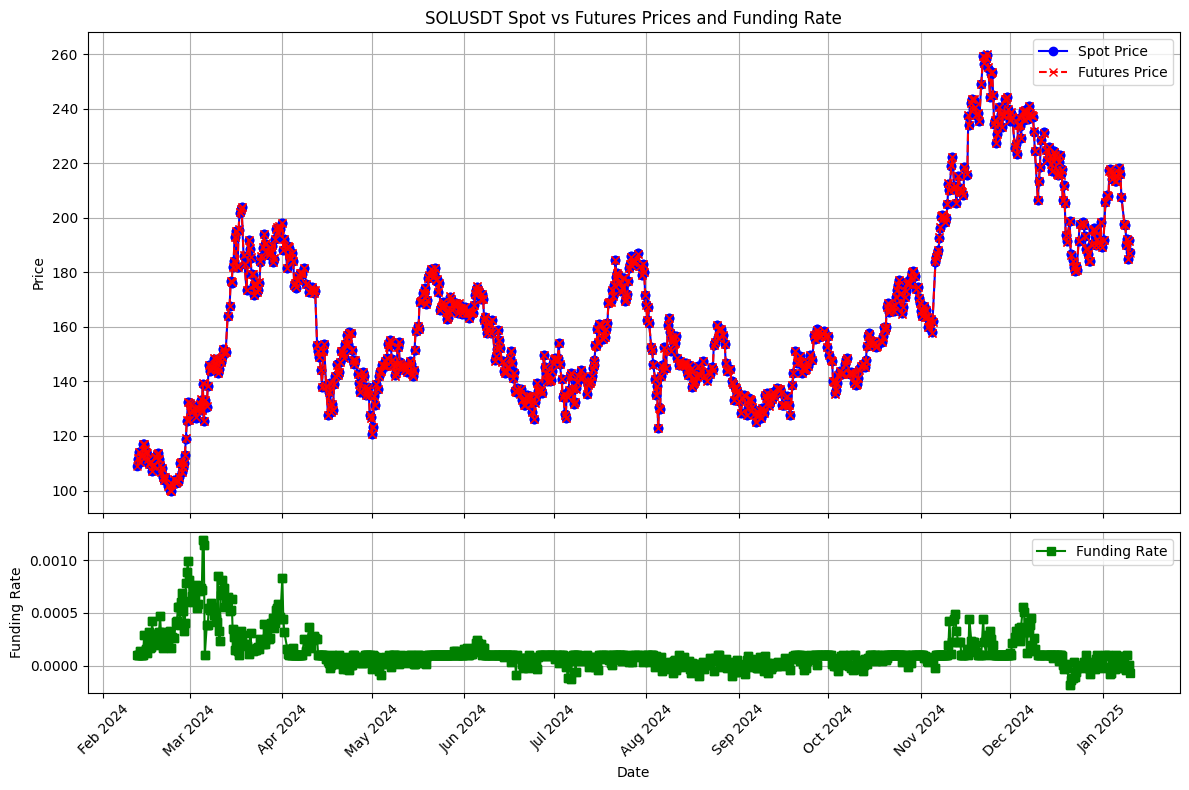

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# First, let's check what format your timestamps are currently in
print("Current timestamp type:", type(df['timestamp'].iloc[0]))
# print("First few timestamps:")
# print(df['timestamp'].head())

# Convert timestamps to datetime explicitly
# If timestamps are strings
if df['timestamp'].dtype == 'object':
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
# If timestamps are integers (unix timestamp)
elif pd.api.types.is_integer_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Print to verify conversion worked correctly
print("After conversion timestamp type:", type(df['timestamp'].iloc[0]))
# print("First few timestamps:")
# print(df['timestamp'].head())
# print("Date range:", df['timestamp'].min(), "to", df['timestamp'].max())

# Create a figure with two subplots sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot spot and futures prices on the first subplot
ax1.plot(df['timestamp'], df['close_spot'], label='Spot Price', marker='o', linestyle='-', color='blue')
ax1.plot(df['timestamp'], df['close_futures'], label='Futures Price', marker='x', linestyle='--', color='red')
ax1.set_ylabel('Price')
ax1.set_title(f'{symbol_input} Spot vs Futures Prices and Funding Rate')
ax1.legend()
ax1.grid(True)

# Plot funding rate on the second subplot
ax2.plot(df['timestamp'], df['funding_rate'], label='Funding Rate', marker='s', linestyle='-', color='green')
ax2.set_ylabel('Funding Rate')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)

# Format x-axis to show only dates at the start of each month
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('financial_data_plot.png', dpi=300)

# Show the plot
plt.show()